## Поиск частых наборов

In [69]:
from collections import defaultdict
from itertools import combinations
import pandas as pd
import csv
import time
from matplotlib import pyplot as plt
import numpy as np

### Датасеты
Для работы используется три датасета.
1. [Датасет потребительской корзины #1](https://www.kaggle.com/irfanasrullah/groceries)
 - 9835 транзакций
 - 169 уникальных предметов
 - 4.4 предмета - средняя длина тразакции
2. [Датасет потребительской корзины #2](https://www.kaggle.com/heeraldedhia/groceries-dataset)
 - 3989 транзакций
 - 167 уникальных предметов
 - 8.9 предметов - cредняя длина тразакции
3. Синтетический датасет [T40I10D100K](http://fimi.uantwerpen.be/data/)
 - 100000 транзакций
 - 943 уникальных предмета
 - 40 предметов - cредняя длина тразакции

In [43]:
def load_dataset_1():
    df = pd.read_csv('dataset1.csv', delimiter=',')
    data = df.iloc[:, 1:].T.apply(lambda x: x.dropna().tolist()).tolist()
    data = [frozenset(l) for l in data]
    return data

def load_dataset_2():
    with open('dataset2.csv') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', )
        next(reader) # skip header
        data = defaultdict(set)
        for row in reader:
            data[row[0]].add(row[2])
        return [frozenset(items) for _,items in data.items()]


def load_dataset_3():
    with open('dataset3.txt') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ', )
        output = [frozenset([item for item in items if item != '']) for items in reader]
        return output

def print_stats(dataset, name):
    print("Dataset", name)
    print(f"\t{len(dataset)} transactions")
    average_items = sum(map(lambda x: len(x), dataset)) / len(dataset)
    print(f"\tAverage transaction length: {average_items:.2f}")
    unique_count = len({item for transaction in dataset for item in transaction})
    print(f"\tUnique items: {unique_count:.2f}")


data1 = load_dataset_1()
print_stats(data1, "Data1")
data2 = load_dataset_2()
print_stats(data2, "Data2")
data3 = load_dataset_3()
print_stats(data3, "Data3")


Dataset Data1
	9835 transactions
	Average transaction length: 4.41
	Unique items: 169.00
Dataset Data2
	3898 transactions
	Average transaction length: 8.92
	Unique items: 167.00
Dataset Data3
	99999 transactions
	Average transaction length: 40.61
	Unique items: 943.00


Реализации всех алгоритмов на вход принимают датасет и минимальную поддержку [0,1]
Возвращают словарь следующего формата:
```
{
 length1: [(itemset1, count),
           (itemset2, count),
           (itemset3, count)],
 length2: [(itemset4, count),
           (itemset5, count)]
}
```
length1, length2, ... - длина набора. Каждой длине соответствует список пар (itemset, count).

### Apriori

#### Вспомогательные функции:
`filter_supports` - возвращает новый сет с удаленными частыми наборами, которые не имеют достаточную поддержку.

`generate_nest_sets` - возвращает новые наборы длины `length+1`, где `length` - длина прошлых наборов.

`count_sets` - считает, сколько раз заданный набор встречается в заданном датасете.

In [89]:
def apriori(data, minsup):
    common_sets = {}
    i = 1
    C = {frozenset({item}) for sublist in data for item in sublist}
    L = filter_supports(data, C, minsup)
    while not len(L) == 0:
        common_sets[i] = L
        i+=1
        # Convert list of pairs [(itemset, count)] into two lists ([itemsets], [counts])
        itemsets, _ = zip(*L)
        C = generate_next_sets(itemsets)
        L = filter_supports(data, C, minsup)
    return common_sets

def filter_supports(data, candidate_sets, minsup):
    supports = set()
    for candidate in candidate_sets:
        c = count_sets(data, candidate)
        if c / len(data) >= minsup:
            supports.add((candidate, c))
    return supports

# Generate next sets of length i+1
def generate_next_sets(previous_sets):
    e = iter(previous_sets).__next__()
    length = len(e) + 1 # Length of current set
    # New candidates for common set
    new_candidates = {i.union(j) for i in previous_sets for j in previous_sets if len(i.union(j)) == length}

    new_candidates_copy = new_candidates.copy()
    for item in new_candidates:
        # Generate all combinations of length i-1 from current candidate
        subsets = combinations(item, length-1)
        for subset in subsets:
            # if the subset is not in previous K-frequent get, then remove the set
            if frozenset(subset) not in previous_sets:
                new_candidates_copy.remove(item)
                break
    return new_candidates_copy

# Count how many times given set appares in all transactions
def count_sets(data, common_set):
    return sum(map(lambda x : common_set.issubset(x), data))

### ECLAT


In [45]:
def eclat(data, minsup):
    common_sets = {}
    length = 1
    # List of items
    C = {frozenset({item}) for sublist in data for item in sublist}
    # Dictionary {item: [transactions]}
    L = {}
    for item in C:
        transactions = {idx for idx, t in enumerate(data) if item.issubset(t)}
        # Remove rare itemsets
        if len(transactions) / len(data) >= minsup:
            L[item] = transactions

    while not len(L) == 0:
        # Save common sets with current length
        common_sets[length] = set()
        for key, value in L.items():
            common_sets[length].add((key, len(value)))
        length+=1
        #Generate candidate common sets of length+1
        C = generate_next_sets(set(L.keys()))
        Lnew = {}
        for itemset in C:
            subsets = combinations(itemset, length-1)
            # Calculate transactions that contain current candidate itemset
            transactions = None
            for subset in subsets:
                if transactions is None :
                    transactions = L[frozenset(subset)].copy()
                else:
                    transactions.intersection_update(L[frozenset(subset)])
            # If it's common, save
            if len(transactions) / len(data) >= minsup:
                Lnew[itemset] = transactions
        L = Lnew
    return common_sets

### FP-Growth
**`FPNode`** - один узел FP дерева. Содержит в себе:
- item - имя предмета (или другой уникальный идентификатор)
- count - количество предметов
- next - дети текущего узла. Словарь вида `{item: FPNode}`
- previous - родитель текущего узла
- next_side - указатель на следующий узел этого же предмета.

**`RootFPNode`** - Наследуется от FPNode, корень FP дерева.
Дополнительно содержит в себе словарь side_nodes вида `{item: (head: [FPNode], tail: [FPNode])`.
Для каждого предмета содержит в себе голову и хвост цепочки, состоящей из узлов данного предмета.

Метод `insert_transaction` вставляет транзакцию в дерево.

In [46]:
# Node of FP Tree
class FPNode:
    def __init__(self, item):
        self.item = item
        self.count = 0
        self.next = {} # Children of current node
        self.previous = None # Parent of current node
        self.next_side = None # Pointer to the next node of same item

    # Return child of current node for given item. Create new node if missing
    def get_or_create(self, item):
        if item not in self.next:
            self.next[item] = FPNode(item)
            self.next[item].previous = self
            return self.next[item], True
        else:
            return self.next[item], False

# Root node. Also contains pointers to the first node of given item
class RootFPNode(FPNode):
    def __init__(self):
        super().__init__(None)
        self.side_nodes = {}

    def add_side_node(self, node):
        # Create new node if not found
        if node.item not in self.side_nodes:
            self.side_nodes[node.item] = (node, node) # first node is head, last is tail
        # Add given node to the end of the chain
        else:
            head, tail = self.side_nodes[node.item]
            tail.next_side = node
            self.side_nodes[node.item] = (head, tail.next_side)

    # Add transaction. Recursively traverse the tree from top to bottom.
    def insert_transaction(self, transaction, count = 1):
        current_node = self
        for item in transaction:
            current_node, created = current_node.get_or_create(item)
            current_node.count += count
            if created:
                self.add_side_node(current_node)

# "List" that always returns 1.
class OneList:
    def __getitem__(self, item):
        return 1

#### Реализация FP-Growth
##### build_fp_tree
Принимает датасет, минимальную поддержку и количество раз, которая каждая тразнакция встречается.
Используется при рекурсивном построении деревьев, по умолчанию 1.

Подсчет каждого предмета, сортировка списка предметов и сортировка предметов в транзакции происходят в данном
методе перед построением дерева.

На выход возвращается указатель на голову дерева, а также список предметов с количеством встреч этих предметов

##### fp_conditional_base
Строит FP Conditional Base из дерева. На вход принимает голову дерева и список предметов (который вернулся методом
 `build_fp_tree`).
Проходит по списку предметов снизу вверх. Для каждого предмета проходит слева направо по ссылкам `FPNode::next_side`
и сохраняет пройденные пути вместе со значением count у листа.

In [47]:
# Build the FP tree
def build_fp_tree(data, minsup, frequency = None):
    # If no transactions are given, return None
    if len(data) == 0:
        return None, None
    # If frequency list is not given (for first iteration), use OneList
    if frequency is None:
        frequency = OneList()

    # Count items
    L = defaultdict(int)
    for idx, transaction in enumerate(data):
        for item in transaction:
            L[item] += frequency[idx]

    # Sort items by count (reversing), filter by support
    # (map preserves insertion order)
    L = {k: counts for k, counts in sorted(L.items(), key=lambda item: item[1], reverse=True) if counts >= minsup}
    map_for_sorting_transactions = {item: idx for idx, item in enumerate(L.keys())}

    head = RootFPNode()
    # Build tree
    for idx, transaction in enumerate(data):
        # Filter rare items
        transaction_sorted = [k for k in transaction if k in map_for_sorting_transactions]
        # Sort items in the same order as L
        transaction_sorted = sorted(transaction_sorted, key=lambda k: (map_for_sorting_transactions[k]))
        if len(transaction_sorted) == 0:
            continue
        head.insert_transaction(transaction_sorted, frequency[idx])
    return head, L # Return order of items for building conditional base and counts for saving support

def fp_conditional_base(tree, item_order):
    output = {}
    # item_order that was returned from build_fp_tree
    for item in reversed(item_order.keys()):
        head = tree.side_nodes[item][0]
        output[item] = []
        while True: # "do-while"
            # Traverse up
            current = head
            count = current.count
            path = []
            while current.previous and current.previous != tree: # Go up while we can
                current = current.previous
                path.append(current.item)
            # Save traversed path
            if len(path) > 0:
                output[item].append((list(reversed(path)), count))
            # Traverse to the side
            head = head.next_side
            if head is None: #exit condition of "do-while"
                break
    return output

##### mine_tree
Производит поиск частых наборов в дереве.
Содержит в себе рекурсивную функцию `mine_tree_internal`, которая принимает текущее дерево, текущий префикс и
порядок предметов item_order, возвращенный функцией `build_fp_tree`.

Изначально фукнция `mine_tree_internal` вызывается для начального fp дерева и с пустым префиксом. После чего строится
conditional base. Далее, итеративно, проходим по всем предметам из `item_order`, создаем копию префикса и добавляем
туда текущий предмет. Префикс сохраняем как частый набор.
Если в conditional base для текущего предмета есть сохраненные пути, для этих путей строится новое дерево и
рекурсивно вызывается функция `mine_tree_inernal` с текущим префиксом и новым деревом.


In [48]:
def mine_tree(tree, item_order, minsup):
    frequent_sets = []

    def mine_tree_internal(tree, prefix, item_order):
        conditional_base = fp_conditional_base(tree, item_order)
        for item, counts in item_order.items():
            # Add current item to prefix and save it as new common set
            new_freq_set = prefix.copy()
            new_freq_set.add(item)
            frequent_sets.append((new_freq_set, counts))
            #If conditional base has for current item has "transactions"
            if len(conditional_base[item]) > 0:
                transactions, frequencies = zip(*(conditional_base[item]))
                # Build another tree
                conditional_tree, new_order = build_fp_tree(transactions, minsup, frequencies)
                # Mine it recursively
                mine_tree_internal(conditional_tree, new_freq_set, new_order)
    mine_tree_internal(tree, set(), item_order)

    return frequent_sets


def fp_growth(data, minsup):
    # Use item count instead of percentage as support, for convenience
    minsup = len(data) * minsup
    head, item_order = build_fp_tree(data, minsup)
    frequent_sets = mine_tree(head, item_order, minsup)
    # Match it with format of other algorithms
    output = defaultdict(set)
    for s, counts in frequent_sets:
        output[len(s)].add((frozenset(s), counts))
    return dict(output)



dummy_data = [frozenset(('I2', 'I1', 'I5')), frozenset(('I2', 'I4')), frozenset(('I2', 'I3')),
              frozenset(('I2', 'I1', 'I4')), frozenset(('I1', 'I3')), frozenset(('I2', 'I3')),
              frozenset(('I1', 'I3')), frozenset(('I2', 'I1', 'I3', 'I5')), frozenset(('I2', 'I1', 'I3')),
              frozenset(('I6',)) ]

frequent_sets = fp_growth(dummy_data, 0.2)

Проверка на то, что алгоритмы возвращают одинаковые наборы.

In [49]:
f1 = apriori(data1, 0.05)
f2 = eclat(data1, 0.05)
f3 = fp_growth(data1, 0.05)
f2 == f2 == f3

True

### Примеры частых наборов

In [86]:
common_sets_example = fp_growth(data2, 0.05)
common_sets_example[3]

{(frozenset({'other vegetables', 'whole milk', 'yogurt'}), 280),
 (frozenset({'rolls/buns', 'soda', 'whole milk'}), 254),
 (frozenset({'other vegetables', 'rolls/buns', 'whole milk'}), 320),
 (frozenset({'other vegetables', 'soda', 'whole milk'}), 270),
 (frozenset({'other vegetables', 'rolls/buns', 'soda'}), 205),
 (frozenset({'rolls/buns', 'whole milk', 'yogurt'}), 257),
 (frozenset({'other vegetables', 'tropical fruit', 'whole milk'}), 197),
 (frozenset({'other vegetables', 'sausage', 'whole milk'}), 196),
 (frozenset({'bottled water', 'other vegetables', 'whole milk'}), 219),
 (frozenset({'soda', 'whole milk', 'yogurt'}), 212),
 (frozenset({'other vegetables', 'rolls/buns', 'yogurt'}), 204)}

### Сравнение скорости
Сравнение происходит на самом большом из имеющихся датасете T40I10D100K

Тестирование производится поддержках от 0.20 до 0.01 с шагом -0.01. Если алгоритм на текущем значении поддержки работал
дольше 5 минут, он исключается из тестирования.

Условие `apriori_result == eclat_result == fp_result` ожидаемо перестает выполняться когда исключается алгоритм Apriori


In [92]:
apriori_times = {}
eclat_times = {}
fp_times = {}
last_apriori_time = 0
last_eclat_time = 0
last_fp_time = 0

def run_benchmark(algorithm, dataset, support):
    start = time.time()
    result = algorithm(dataset, support)
    return time.time() - start, result

apriori_result = None
eclat_result = None
fp_result = None

for support in range(20, 0, -1):
    support = support / 100
    print(f"Support - {support:.2f}")
    if last_apriori_time < 300: # 5 minutes
        last_apriori_time, apriori_result = run_benchmark(apriori, data3, support)
        apriori_times[support] = last_apriori_time
        print(f"\tApriori: Time - {last_apriori_time:.1f}s")

    if last_eclat_time < 300: # 5 minutes
        last_eclat_time, eclat_result = run_benchmark(eclat, data3, support)
        eclat_times[support] = last_eclat_time
        print(f"\tEclat: Time - {last_eclat_time:.1f}s")

    if last_fp_time < 300: # 5 minutes
        last_fp_time, fp_result = run_benchmark(fp_growth, data3, support)
        fp_times[support] = last_fp_time
        print(f"\tFP: Time - {last_fp_time:.1f}s")

    if apriori_result == eclat_result == fp_result:
        print("\tOK")

Support - 0.20
	Apriori: Time - 28.3s
	Eclat: Time - 23.1s
	FP: Time - 1.4s
	OK
Support - 0.19
	Apriori: Time - 28.1s
	Eclat: Time - 22.8s
	FP: Time - 1.4s
	OK
Support - 0.18
	Apriori: Time - 28.6s
	Eclat: Time - 22.9s
	FP: Time - 1.4s
	OK
Support - 0.17
	Apriori: Time - 30.0s
	Eclat: Time - 23.0s
	FP: Time - 1.5s
	OK
Support - 0.16
	Apriori: Time - 32.0s
	Eclat: Time - 23.1s
	FP: Time - 1.6s
	OK
Support - 0.15
	Apriori: Time - 33.0s
	Eclat: Time - 23.1s
	FP: Time - 1.7s
	OK
Support - 0.14
	Apriori: Time - 36.6s
	Eclat: Time - 23.2s
	FP: Time - 2.0s
	OK
Support - 0.13
	Apriori: Time - 48.5s
	Eclat: Time - 24.2s
	FP: Time - 13.0s
	OK
Support - 0.12
	Apriori: Time - 67.7s
	Eclat: Time - 26.0s
	FP: Time - 7.9s
	OK
Support - 0.11
	Apriori: Time - 92.3s
	Eclat: Time - 26.6s
	FP: Time - 10.9s
	OK
Support - 0.10
	Apriori: Time - 138.6s
	Eclat: Time - 27.8s
	FP: Time - 13.7s
	OK
Support - 0.09
	Apriori: Time - 223.8s
	Eclat: Time - 28.4s
	FP: Time - 18.7s
	OK
Support - 0.08
	Apriori: Time - 31

#### Визуализация времени работы

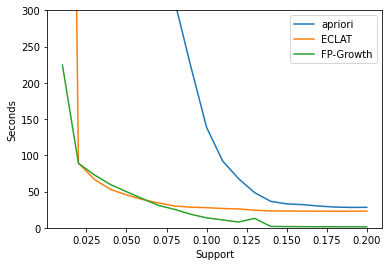

In [93]:
_, ax = plt.subplots()
ax.plot(*zip(*apriori_times.items()), label='apriori')
ax.plot(*zip(*eclat_times.items()), label='ECLAT')
ax.plot(*zip(*fp_times.items()), label='FP-Growth')
ax.set_ylim(0, 300)

ax.set_ylabel("Seconds")
ax.set_xlabel("Support")
ax.legend()

### Остальная статистика
Использовался датасет T40I10D100K и алгоритм FP-Growth.
Значения поддержки от 0.20 до 0.01 с шагом -0.01.

Сохраняем частые наборы для разных значений поддержки

In [53]:
frequent_sets = {}
for support in range(20, 0, -1):
    support = support / 100
    frequent_sets[support] = fp_growth(data3, support)
    print(f"support: {support:.2f}", end='\r')
print()

support: 0.01


#### Подсчет и визуализация количества частых наборов в зависимости от значения поддержки


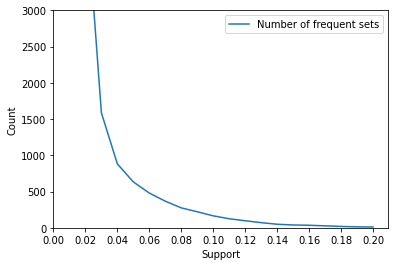

In [79]:
frequent_sets_counts = {}

for support in range(20, 0, -1):
    support = support / 100
    sets = frequent_sets[support]
    frequent_sets_counts[support] = sum(map(lambda x: len(x[1]), sets.items()))


_, ax = plt.subplots()
ax.plot(*zip(*frequent_sets_counts.items()), label='Number of frequent sets')
ax.set_ylabel("Count")
ax.set_xlabel("Support")
ax.set_xticks(np.arange(0, 0.22, 0.02))
ax.set_ylim(0, 3000)
ax.legend()

### Подсчет и визуализация максимальной длины набора в зависимости от значения поддержки

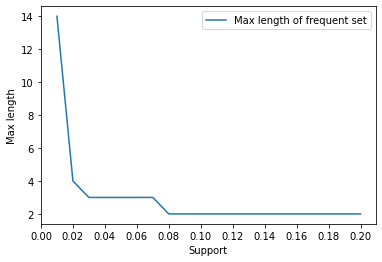

In [73]:
frequent_sets_max_length = {}

for support in range(20, 0, -1):
    support = support / 100
    sets = frequent_sets[support]
    frequent_sets_max_length[support] = max(map(lambda x: float(x[0]), sets.items()))


_, ax = plt.subplots()
ax.plot(*zip(*frequent_sets_max_length.items()), label='Max length of frequent set')
ax.set_ylabel("Max length")
ax.set_xlabel("Support")
ax.set_xticks(np.arange(0, 0.22, 0.02))
ax.legend()

### Подсчет и визуализация количества частых наборов объектов различной длины в зависимости от значения поддержки

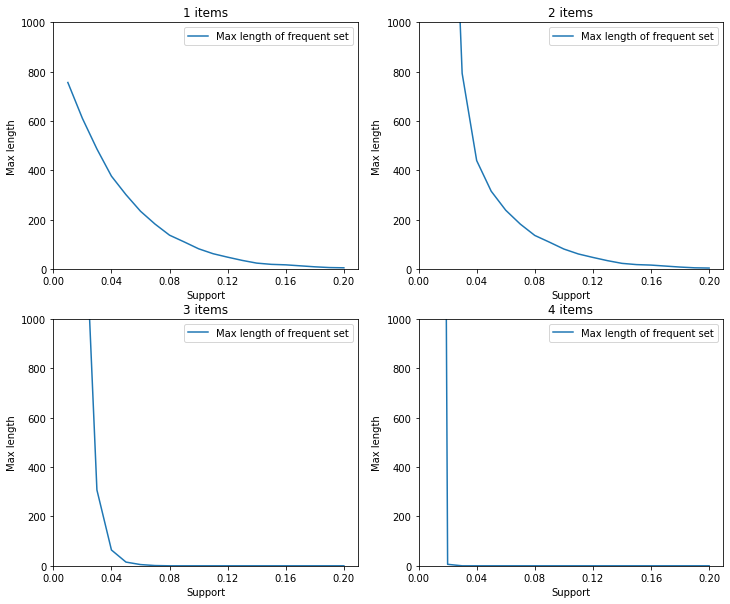

In [80]:
_, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, count in enumerate([1,2,3,4]):
    frequent_sets_counts = {}

    for support in range(20, 0, -1):
        support = support / 100
        if count in frequent_sets[support]:
            sets = frequent_sets[support][count]
        else:
            sets = {}
        frequent_sets_counts[support] = len(sets)

    ax = axes[idx // 2, idx % 2]
    ax.plot(*zip(*frequent_sets_counts.items()), label='Max length of frequent set')
    ax.set_ylabel("Max length")
    ax.set_xlabel("Support")
    ax.set_ylim(0, 1000)
    ax.set_xticks(np.arange(0, 0.22, 0.04))
    ax.legend()
    ax.set_title(f"{count} items")